# Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler 
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.feature_selection import RFECV

%matplotlib inline

# Read data and only keep needed class

In [2]:
user = pd.read_csv("analysis_data.csv", sep=",", index_col="Client")
print(user.shape)

(1566, 41)


In [3]:
user_tr = user[pd.notnull(user['Sale_MF'])]
print(user_tr.shape)

(937, 41)


In [4]:
user_tr = user_tr.drop(['Sale_MF','Sale_CC','Revenue_MF','Revenue_CC','Revenue_CL'], axis=1)


In [5]:
user_tr_X = user_tr.drop('Sale_CL', axis=1)

user_tr_Y = user_tr['Sale_CL']

## Check target data set

(937, 35)


(array([ 655.,  282.]), array([ 0. ,  0.5,  1. ]), <a list of 2 Patch objects>)

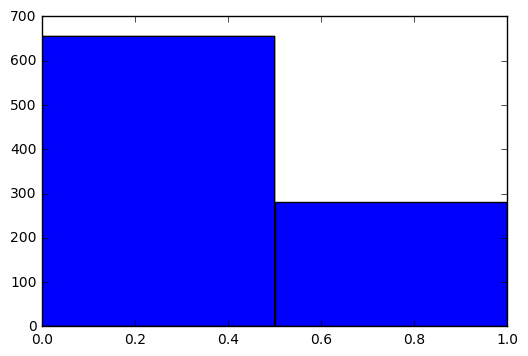

In [6]:
print(user_tr_X.shape)
plt.hist(user_tr_Y, bins=2)

It is clear the data is inbalanced in favor of the 0. This will be solved in the preprocessing step by adding random
rows with class 1 untill the data is balanced.

## Missing data

In [7]:
#missing data
total = user_tr_X.isnull().sum().sort_values(ascending=False)
percent = (user_tr_X.isnull().sum()/user_tr_X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
ActBal_CL_avg,0,0.0
Count_CL,0,0.0
ActBal_CL,0,0.0
ActBal_CC,0,0.0
ActBal_OVD,0,0.0
ActBal_MF,0,0.0
ActBal_SA,0,0.0
ActBal_CA,0,0.0
Count_CC,0,0.0
VolumeCred_CA,0,0.0


# Preprocessing of the data

## check for skewness and log transform if needed

In [8]:
#log transform skewed numeric features:
user_skew = user_tr_X.drop('M', axis=1)
skewed_feats = user_skew.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

user_tr_X[skewed_feats] = np.log1p(user_tr_X[skewed_feats])

In [9]:
user_tr_X.replace(np.NaN, 0, inplace=True)

## Remove outliers

This was already done during EDA for the most extreme cases. I have added this code for further outlier removal but this did not improve the performance of the models.
This because the code assumes a normal distribution and most of the data is not distributed like this.

In [10]:
#for col in user_tr_X.columns:
#    index = user_tr_X[np.abs(user_tr_X[col]-user_tr_X[col].mean())>(3*user_tr_X[col].std())].index.values
#    user_tr_X.drop(index, inplace = True)
#    user_tr_Y.drop(index, inplace = True)

## Upsampling

Upsampling is done to fix the class imbalance

In [11]:
ros = RandomOverSampler(random_state=42)
user_tr_X, user_tr_Y = ros.fit_sample(user_tr_X,user_tr_Y)

# Model selection

Different models will be tested using cross validation based on the roc auc

## Test with basic data

In [12]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



roc_auc: 0.66 (+/- 0.08)


In [13]:
random_forest = RandomForestClassifier(n_estimators = 20)
scores = cross_val_score(random_forest, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.9407 (+/- 0.12)


In [14]:
gaussian = GaussianNB()
scores = cross_val_score(gaussian, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.58 (+/- 0.10)


## Scale the data for support vector algo

In [15]:
#Scale the data
user_tr_X_scale = scale(user_tr_X)

In [16]:
svc = SVC(kernel='rbf', degree=2, random_state=101)
scores = cross_val_score(svc, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

roc_auc: 0.76 (+/- 0.13)
[ 0.68089991  0.67125803  0.75022957  0.76859504  0.77043159  0.8608284
  0.69491124  0.83195266  0.82650888  0.72781065]


In [17]:
svc = SVC(kernel='linear', degree=2, random_state=101)
scores = cross_val_score(svc, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print(scores)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



KeyboardInterrupt: 

## PCA

Some PCA is done to see if this might improve the model. 
The number of dimensions to keep is based on the correlation done in the EDA

In [18]:
#dimension reduction
pca = PCA(n_components=8)
X_pca_20 = pca.fit_transform(user_tr_X)
X_pca_20.shape

(1310, 8)

In [ ]:
random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, X_pca_20, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.9226 (+/- 0.14)


### It is clear the randomforest algo is the best algo for the classification. This will be futher optimised and used for the prediction

# Optimize the algorithm

In [ ]:
search = { "n_estimators"      : [20, 50, 75],
           "criterion"         : ["gini", "entropy"],
           "max_features"      : [5, 10,15],
           "max_depth"         : [20,30, 40],
           "min_samples_split" : [2, 4,6] ,
           "bootstrap": [True, False]}


randfor = RandomForestClassifier()

randfor_grid = GridSearchCV(estimator=randfor,param_grid=search, scoring='roc_auc', n_jobs=-1,refit=True, cv=10)

randfor_grid.fit( user_tr_X, user_tr_Y)

print(randfor_grid.best_estimator_)

print(randfor_grid.best_params_)

print(randfor_grid.best_score_)

# Fit the model and predict the missing values

Get the values to predict

In [ ]:
user_pr = user[pd.isnull(user['Sale_MF'])]
print(user_pr.shape)

In [ ]:
user_pr = user_pr.drop(['Sale_MF','Sale_CL','Sale_CC','Revenue_MF','Revenue_CC','Revenue_CL'], axis=1)

In [ ]:
user_pr_Y = randfor_grid.predict( user_pr)

In [ ]:
plt.hist(user_pr_Y, bins=2)

In [ ]:
user_pr['Sale_CL_pred'] = pd.Series(user_pr_Y,index=user_pr.index)

In [ ]:
user_pr.to_csv(path_or_buf='consumer_loan_prop_pred.csv')